# Model to Determine FSC = 0 or FSC = 1 from ICESat-2 Data

## Sodankyla

### Creation of Pandas Dataframe

In [2]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, cmap2, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
import seaborn as sns
from scripts.classes_fixed import *
from scripts.track_pairs import *
from scripts.show_tracks import *
from scripts.parallel import pvpg_parallel

# Function to compute mean without the warning
def safe_nanmean(slice):
    if len(slice) == 0 or np.isnan(slice).all():
        return np.nan
    else:
        return np.nanmean(slice)

# %matplotlib ipympl

dirpath = '../data/sodankyla_cam/'
all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

In [3]:
csv_path = 'snow_cam_details.csv'
df = pd.read_csv(csv_path).dropna().drop('Image', axis=1)

In [4]:
pvpg = []
mean_Eg_strong = []
mean_Eg_weak = []
mean_Ev_strong = []
mean_Ev_weak = []
msw_flags = []
night_flags = []
asrs = []

for i in df['File Number']:
    coefs,means,msw_flag,night_flag,asr = pvpg_parallel(all_ATL03[int(i)], all_ATL08[int(i)], file_index = int(i))
    pvpg.append(-coefs[0])
    mean_Eg_strong.append(safe_nanmean(means[0]))
    mean_Eg_weak.append(safe_nanmean(means[1]))
    mean_Ev_strong.append(safe_nanmean(means[2]))
    mean_Ev_weak.append(safe_nanmean(means[3]))
    msw_flags.append(msw_flag)
    night_flags.append(night_flag)
    asrs.append(asr)

df['pvpg'] = pvpg
df['mean_Eg_strong'] = mean_Eg_strong
df['mean_Eg_weak'] = mean_Eg_weak
df['mean_Ev_strong'] = mean_Ev_strong
df['mean_Ev_weak'] = mean_Ev_weak
df['msw_flag'] = msw_flags
df['night_flag'] = night_flags
df['asr'] = asrs

#make categorical column
df['Joint Snow'] = df['Joint Snow'].astype('category')
df['FSC'] = df['FSC'].astype('category')
df['Tree Snow'] = df['Tree Snow'].astype('category')

Beam 6 in file 1 has been skipped because of no data.
Beam 4 in file 10 has been skipped because of no data.
Beam 6 in file 16 has been skipped because of no data.


In [5]:
df_pure = df.drop(['Camera','Date'], axis=1)

### Statistical Glance

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 0 to 22
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Camera          23 non-null     object  
 1   File Number     23 non-null     float64 
 2   Date            23 non-null     object  
 3   FSC             23 non-null     category
 4   Tree Snow       23 non-null     category
 5   Joint Snow      23 non-null     category
 6   pvpg            23 non-null     float64 
 7   mean_Eg_strong  23 non-null     float32 
 8   mean_Eg_weak    22 non-null     float64 
 9   mean_Ev_strong  23 non-null     float32 
 10  mean_Ev_weak    22 non-null     float64 
 11  msw_flag        23 non-null     float64 
 12  night_flag      23 non-null     float64 
 13  asr             23 non-null     float64 
dtypes: category(3), float32(2), float64(7), object(2)
memory usage: 2.4+ KB


In [7]:
df.head()

,Camera,File Number,Date,FSC,Tree Snow,Joint Snow,pvpg,mean_Eg_strong,mean_Eg_weak,mean_Ev_strong,mean_Ev_weak,msw_flag,night_flag,asr
0,Sodankyla Intensive Observation Area,0.0,12/01/2019,1.0,0.0,1.0,1.312406,4.024636,1.223947,0.432143,0.289866,1.000000,1.0,0.312751
1,Sodankyla Intensive Observation Area,1.0,24/01/2019,1.0,1.0,2.0,1.229192,0.277724,0.183511,0.411869,0.289517,3.000000,0.0,0.083229
2,Sodankyla Intensive Observation Area,2.0,27/03/2019,1.0,0.0,1.0,0.651901,0.260734,NaN,0.126290,NaN,2.181818,0.0,0.017572
3,Sodankyla Intensive Observation Area,3.0,13/04/2019,1.0,0.0,1.0,1.017360,3.063679,0.813262,0.220803,0.341194,1.000000,0.0,0.298695
4,Sodankyla Intensive Observation Area,4.0,25/04/2019,1.0,0.0,1.0,0.515518,3.112622,0.663740,0.350935,0.189513,0.000000,0.0,0.329401


In [8]:
df.describe()

,File Number,pvpg,mean_Eg_strong,mean_Eg_weak,mean_Ev_strong,mean_Ev_weak,msw_flag,night_flag,asr
count,23.000000,23.000000,23.000000,22.000000,23.000000,22.000000,23.000000,23.000000,23.000000
mean,16.391304,0.785563,2.329018,0.715239,0.567271,0.328744,0.916740,0.391304,0.231732
std,10.882593,0.347100,1.629436,0.459035,0.341207,0.122649,0.996288,0.499011,0.168069
min,0.000000,0.218932,0.260734,0.090498,0.126290,0.189513,0.000000,0.000000,0.017572
25%,6.500000,0.526784,0.998561,0.251957,0.389122,0.252141,0.000000,0.000000,0.096824
50%,17.000000,0.770523,2.166465,0.640000,0.501309,0.292569,1.000000,0.000000,0.194624
75%,24.500000,1.037282,3.837193,1.133937,0.659664,0.365419,1.456522,1.000000,0.321076
max,35.000000,1.312406,5.823964,1.506051,1.815182,0.724196,3.000000,1.000000,0.563207


<Axes: >

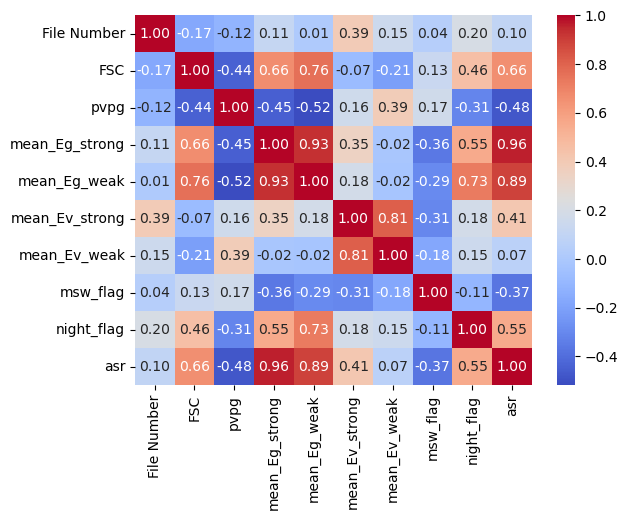

In [9]:
# Correlation heatmap
sns.heatmap(df_pure.drop(['Joint Snow','Tree Snow'],axis=1).corr(), annot=True, cmap="coolwarm", fmt=".2f")

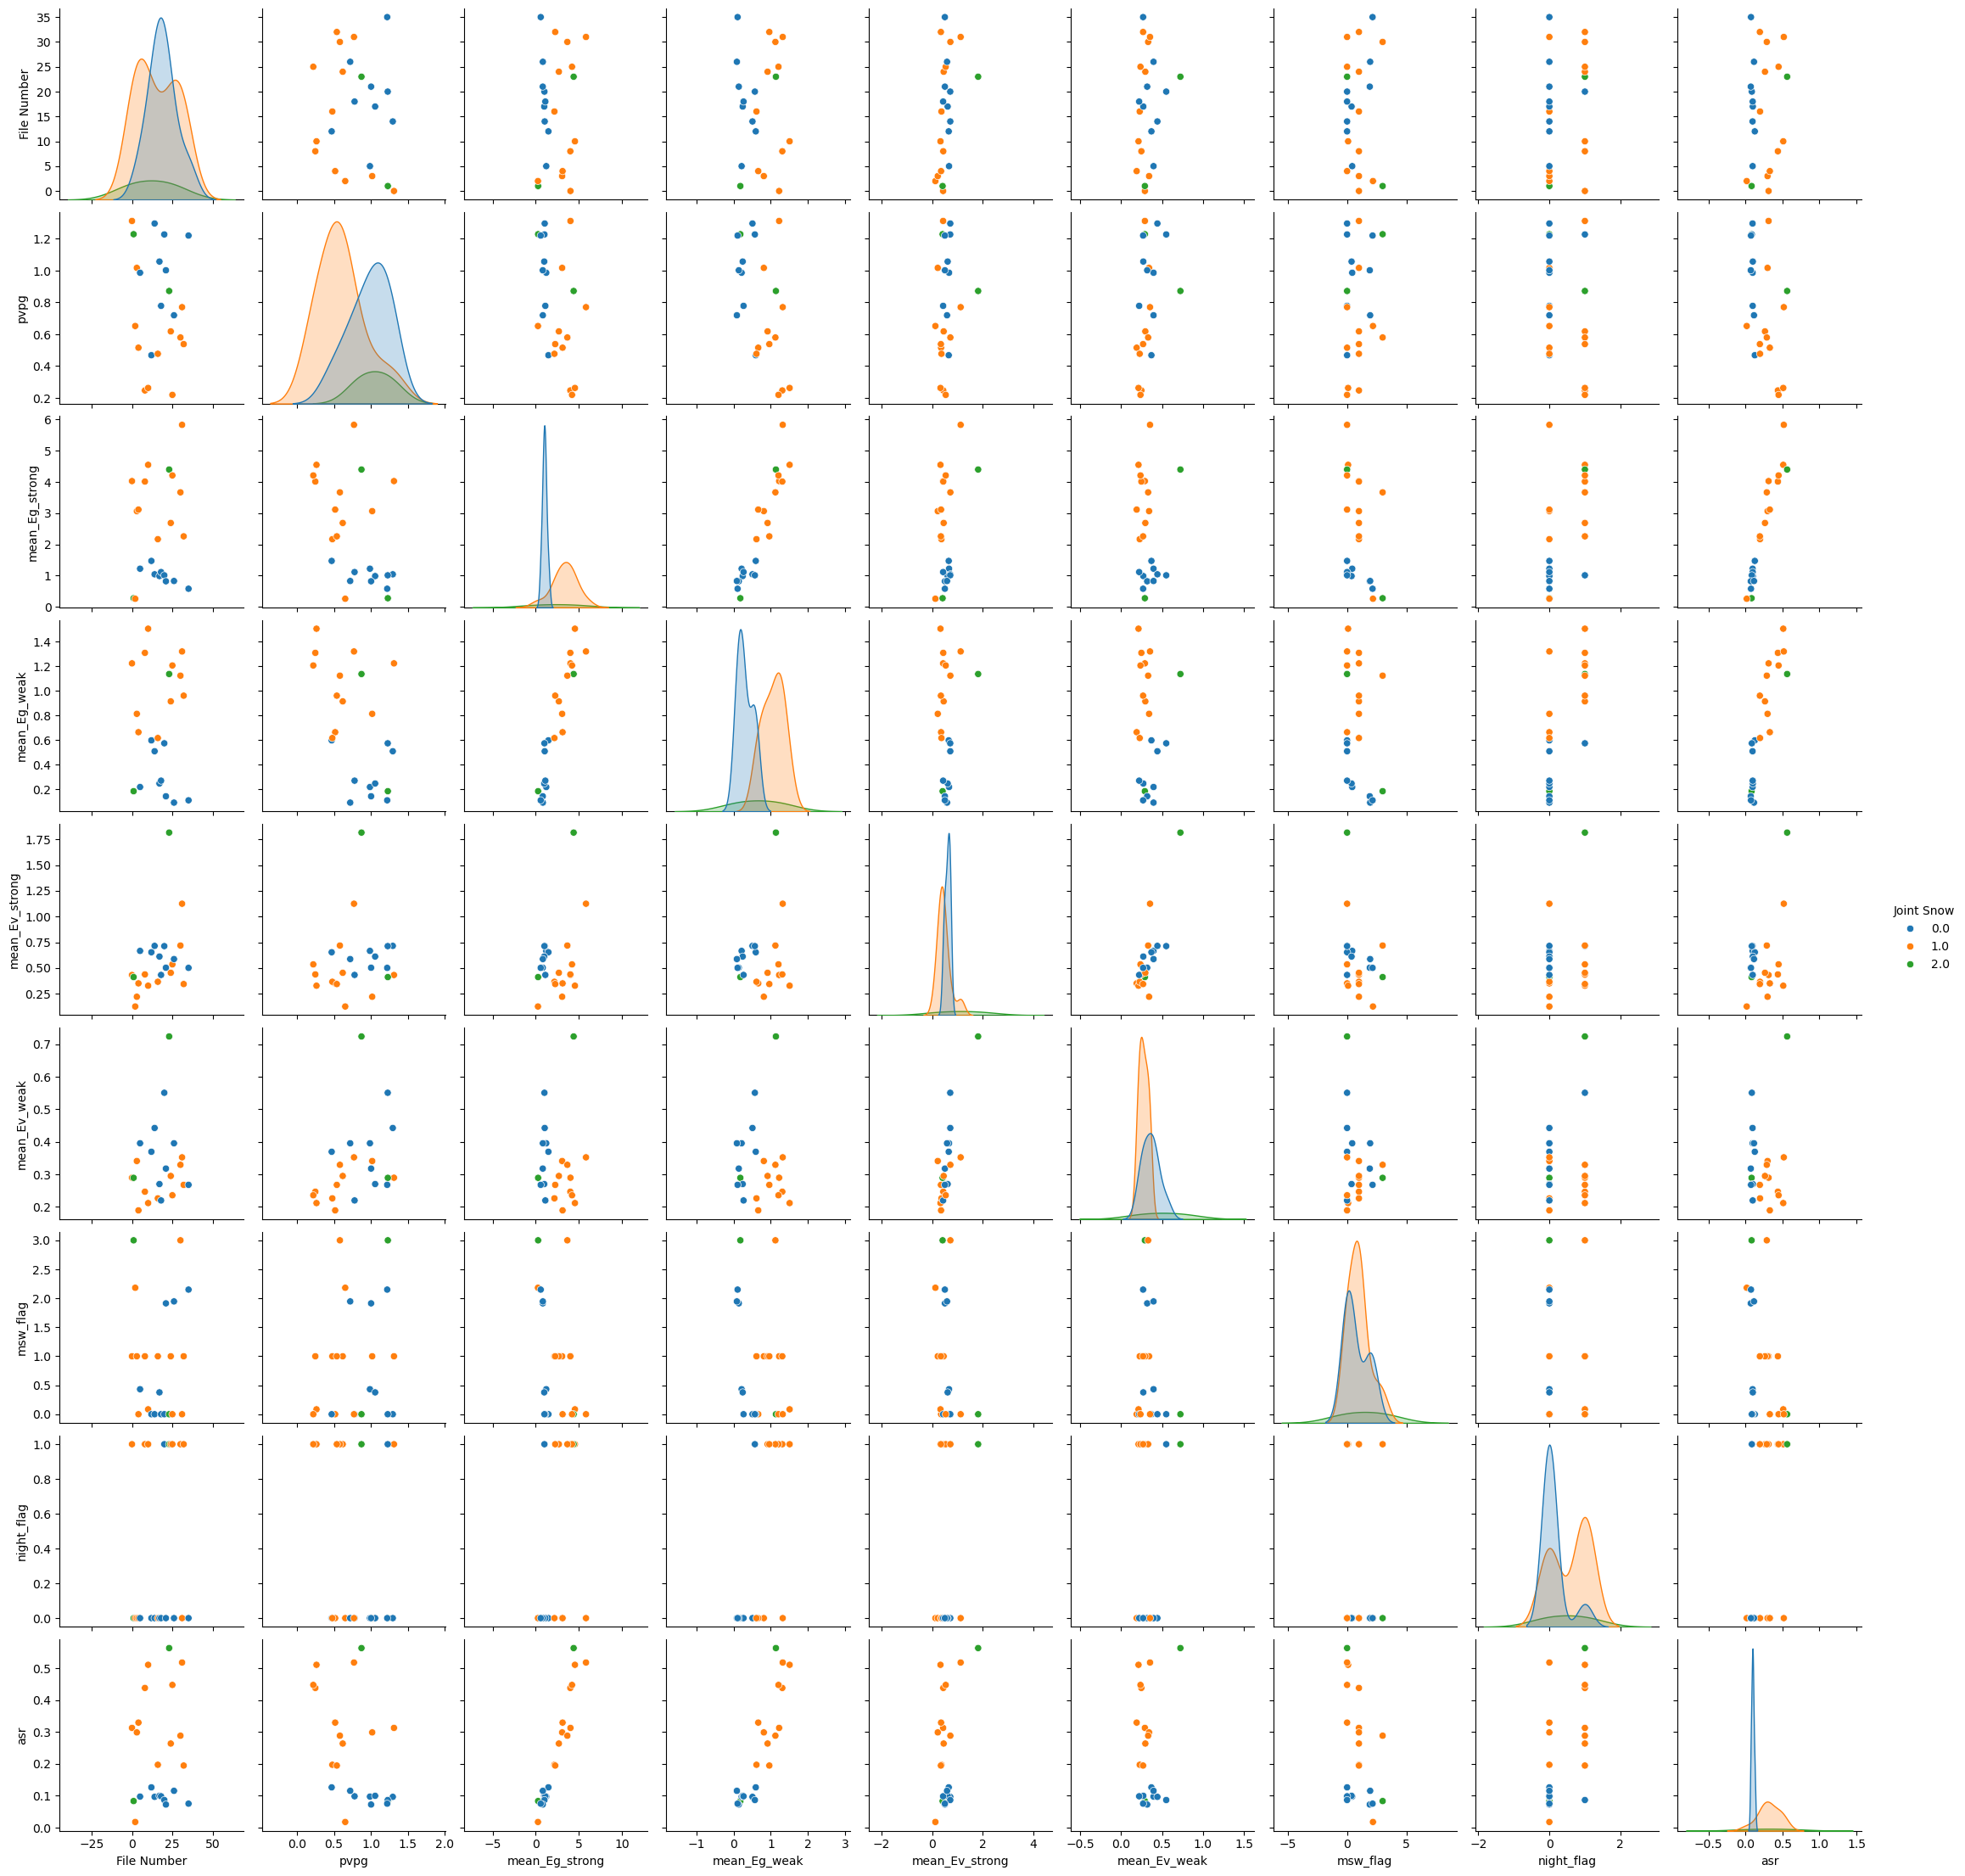

In [10]:
# Pairplot
hue = 'Joint Snow'

sns.pairplot(df_pure, diag_kind='kde', hue=hue)

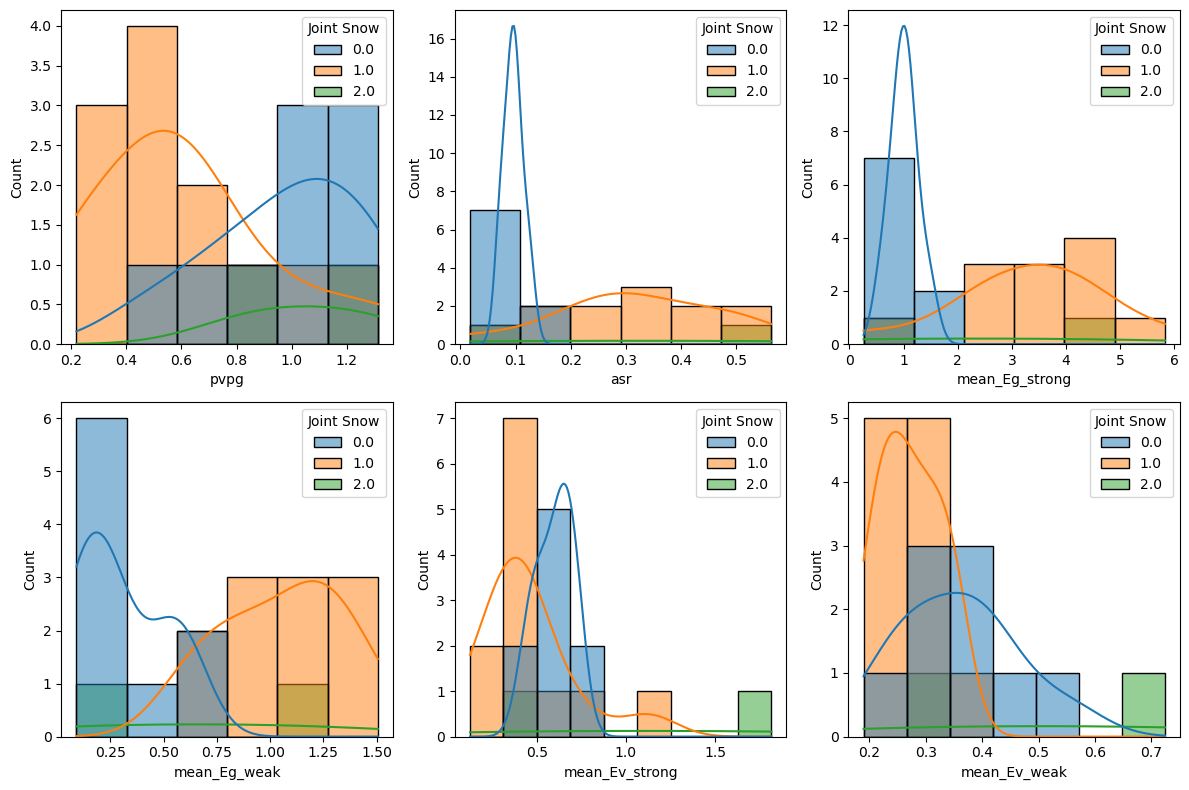

In [11]:
# Distribution Plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

hue = 'Joint Snow'

# Distribution plots
sns.histplot(df, x='pvpg', hue=hue, kde=True, ax=axes[0, 0])
sns.histplot(df, x='asr', hue=hue, kde=True, ax=axes[0, 1])
sns.histplot(df, x='mean_Eg_strong', hue=hue, kde=True, ax=axes[0, 2])
sns.histplot(df, x='mean_Eg_weak', hue=hue, kde=True, ax=axes[1, 0])
sns.histplot(df, x='mean_Ev_strong', hue=hue, kde=True, ax=axes[1, 1])
sns.histplot(df, x='mean_Ev_weak', hue=hue, kde=True, ax=axes[1, 2])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

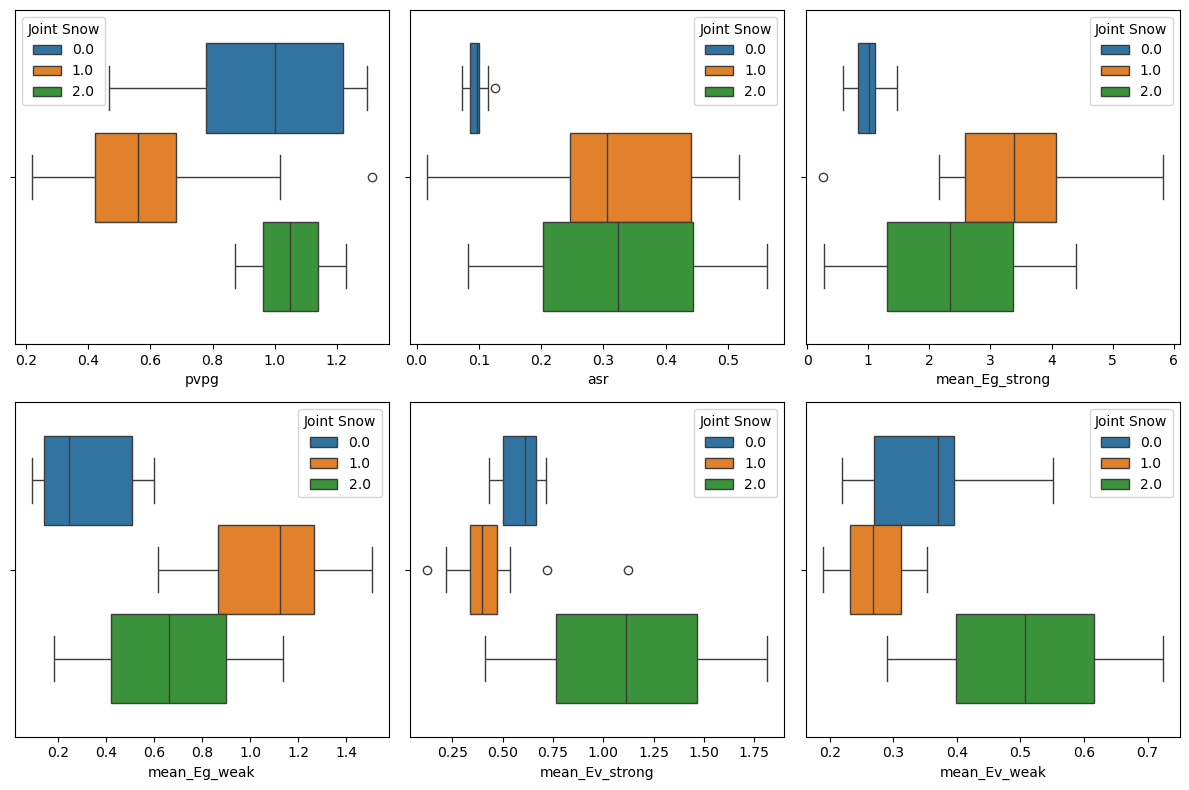

In [11]:
# Boxplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
hue = 'Joint Snow'
# Distribution plots
sns.boxplot(df, x='pvpg', hue=hue, ax=axes[0, 0])
sns.boxplot(df, x='asr', hue=hue, ax=axes[0, 1])
sns.boxplot(df, x='mean_Eg_strong', hue=hue, ax=axes[0, 2])
sns.boxplot(df, x='mean_Eg_weak', hue=hue, ax=axes[1, 0])
sns.boxplot(df, x='mean_Ev_strong', hue=hue, ax=axes[1, 1])
sns.boxplot(df, x='mean_Ev_weak', hue=hue, ax=axes[1, 2])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

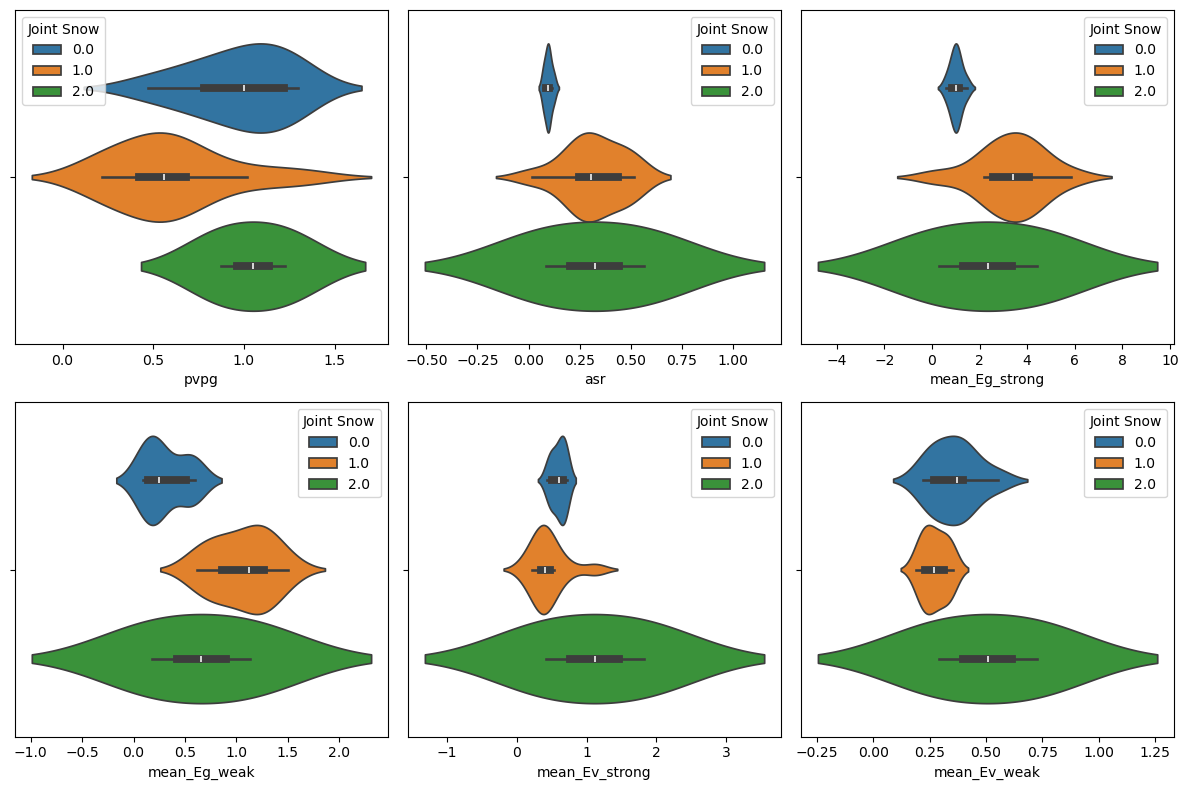

In [12]:
# Violin plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

hue = 'Joint Snow'

# Distribution plots
sns.violinplot(df, x='pvpg', hue=hue, ax=axes[0, 0])
sns.violinplot(df, x='asr', hue=hue, ax=axes[0, 1])
sns.violinplot(df, x='mean_Eg_strong', hue=hue, ax=axes[0, 2])
sns.violinplot(df, x='mean_Eg_weak', hue=hue, ax=axes[1, 0])
sns.violinplot(df, x='mean_Ev_strong', hue=hue, ax=axes[1, 1])
sns.violinplot(df, x='mean_Ev_weak', hue=hue, ax=axes[1, 2])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Kenttarova

In [ ]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, cmap2, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
import seaborn as sns
from scripts.classes_fixed import *
from scripts.track_pairs import *
from scripts.show_tracks import *
from scripts.parallel import pvpg_parallel

# Function to compute mean without the warning
def safe_nanmean(slice):
    if len(slice) == 0 or np.isnan(slice).all():
        return np.nan
    else:
        return np.nanmean(slice)

# %matplotlib ipympl

dirpath = '../data/kenttarova_cam/'
all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)